In [56]:
#import libraries
import numpy as np
import pandas as pd
import os
from random import choice, randint
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [4]:
#load the dataset into a pandas dataframe
file_path = os.path.join('data', 'Booking_Data_Cleaned.csv')
df = pd.read_csv(file_path)

In [5]:
df.head()

,Hotel,Booking Date,Arrival Date,Lead Time,Nights,Guests,Distribution Channel,Customer Type,Country,Deposit Type,...,Stay Duration Category,Revenue Category,Revenue Loss Category,ADR Category,Booking Month,Booking Day,Arrival Month,Arrival Day,Booking Year,Arrival Year
0,Resort,2014-07-24,2015-07-01,342,0,2,Direct,Transient,Portugal,No Deposit,...,short,low,low,low,July,Thursday,July,Wednesday,2014,2015
1,Resort,2015-06-24,2015-07-01,7,1,1,Direct,Transient,United Kingdom,No Deposit,...,short,low,low,low,June,Wednesday,July,Wednesday,2015,2015
2,Resort,2015-06-18,2015-07-01,13,1,1,Corporate,Transient,United Kingdom,No Deposit,...,short,low,low,low,June,Thursday,July,Wednesday,2015,2015
3,Resort,2015-06-17,2015-07-01,14,2,2,Online Travel Agent,Transient,United Kingdom,No Deposit,...,short,medium,low,low,June,Wednesday,July,Wednesday,2015,2015
4,Resort,2015-06-17,2015-07-01,14,2,2,Online Travel Agent,Transient,United Kingdom,No Deposit,...,short,medium,low,low,June,Wednesday,July,Wednesday,2015,2015


We know that the dataset very imabalanced from univariate analysis of Cancelled column. Lets balance the dataset using SMOTE method

In [9]:

# Separating features and target variable
X = df.drop(['Cancelled (0/1)'], axis=1)
y = df['Cancelled (0/1)']

# Identifying categorical columns for one-hot encoding
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Creating a preprocessing pipeline for automatic one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  # Passthrough numerical columns as they are
)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify categorical and numerical columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X_train.select_dtypes(exclude=['object', 'category']).columns.tolist()

# Create a column transformer with appropriate transformers for categorical and numerical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Fit the preprocessor and transform the training data
X_train_processed = preprocessor.fit_transform(X_train)

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Fit SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

# Checking the balance after SMOTE
print(f"Before SMOTE, counts of label '1': {sum(y_train == 1)}")
print(f"Before SMOTE, counts of label '0': {sum(y_train == 0)}\n")
print(f"After SMOTE, counts of label '1': {sum(y_train_smote == 1)}")
print(f"After SMOTE, counts of label '0': {sum(y_train_smote == 0)}")


Before SMOTE, counts of label '1': 32084
Before SMOTE, counts of label '0': 57471

After SMOTE, counts of label '1': 57471
After SMOTE, counts of label '0': 57471


In [26]:
# Encoding categorical features
le = LabelEncoder()
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = le.fit_transform(df[column])

# Separating features and target variable
X = df.drop('Cancelled (0/1)', axis=1)
y = df['Cancelled (0/1)']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fitting the model
rf.fit(X_train, y_train)

# Predicting the test set results
y_pred = rf.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Getting feature importances
feature_importances = rf.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

accuracy, report, importance_df.head(10)


(1.0,
 '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00     14301\n           1       1.00      1.00      1.00      8088\n\n    accuracy                           1.00     22389\n   macro avg       1.00      1.00      1.00     22389\nweighted avg       1.00      1.00      1.00     22389\n',
                   Feature  Importance
 11                 Status    0.421396
 14           Revenue Loss    0.160363
 9            Deposit Type    0.123701
 13                Revenue    0.117945
 19  Revenue Loss Category    0.086549
 18       Revenue Category    0.020037
 3               Lead Time    0.011125
 12          Status Update    0.010241
 8                 Country    0.009918
 16     Lead Time Category    0.009582)

The Random Forest model achieved an accuracy of 100% on the test set, which suggests that the model might be overfitting to the training data. This high accuracy could also indicate a leakage of target information into the features, especially since some features like "Status" and "Revenue Loss" show very high importance. In real-world scenarios, achieving 100% accuracy is highly unlikely, pointing to the need for careful examination of the data and feature selection process to ensure no data leakage or overfitting occurs.

The top 10 most important features according to the Random Forest model are:

* Status: This feature has the highest importance, but it likely leaks information about the cancellation status, suggesting it should not be used for prediction.
* Revenue Loss: Indicates the loss incurred from cancellations, which directly relates to whether a booking was cancelled.
* Deposit Type: The type of deposit may influence cancellation likelihood.
* Revenue: Total revenue may also be directly affected by cancellations.
* Revenue Loss Category: Categorized revenue loss from cancellations.
* Revenue Category: Categorized revenue information.
* Lead Time: The time between booking and arrival.
* Status Update: May contain information related to booking status changes.
* Country: The country of the guest.
* Lead Time Category: Categorized lead time.

Given these findings, it's crucial to remove features that might directly reveal the target variable, such as "Status" and "Revenue Loss", to prevent data leakage and ensure the model generalizes well to unseen data.

In [47]:
# Dropping columns that are directly related to the outcome or post-outcome
columns_to_drop = ['Status', 'Revenue Loss', 'Deposit Type', 'Revenue', 
                   'Revenue Loss Category', 'Revenue Category', 'Status Update']

# Dropping the identified columns from the dataset
X_reduced = X.drop(columns_to_drop, axis=1)

# Splitting the reduced dataset into training and testing sets
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Fitting the Random Forest model on the reduced dataset
rf_reduced = RandomForestClassifier(n_estimators=100, random_state=42)
rf_reduced.fit(X_train_reduced, y_train)

# Predicting the test set results
y_pred_reduced_rf = rf_reduced.predict(X_test_reduced)

# Evaluating the model on the reduced dataset
accuracy_reduced = accuracy_score(y_test, y_pred_reduced_rf)
report_reduced = classification_report(y_test, y_pred_reduced_rf)

# Getting feature importances from the reduced model
feature_importances_reduced = rf_reduced.feature_importances_
features_reduced = X_reduced.columns
importance_df_reduced = pd.DataFrame({'Feature': features_reduced, 'Importance': feature_importances_reduced}).sort_values(by='Importance', ascending=False)

print("Results after dropping columns directly related to the outcome or post-outcome:")
print("Random Forest Classifier:")
print("Accuracy:", accuracy_reduced)
print("Classification Report:\n", report_reduced)
print("Top 10 most important features:\n", importance_df_reduced.head(10))



Results after dropping columns directly related to the outcome or post-outcome:
Random Forest Classifier:
Accuracy: 0.8507749341194336
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.93      0.89     14301
           1       0.85      0.71      0.78      8088

    accuracy                           0.85     22389
   macro avg       0.85      0.82      0.83     22389
weighted avg       0.85      0.85      0.85     22389

Top 10 most important features:
                  Feature  Importance
8                Country    0.163059
3              Lead Time    0.138714
1           Booking Date    0.098654
9         Avg Daily Rate    0.094730
2           Arrival Date    0.087395
15           Booking Day    0.043591
6   Distribution Channel    0.043192
17           Arrival Day    0.042784
4                 Nights    0.042215
11    Lead Time Category    0.041442


ROC-AUC for Random forest

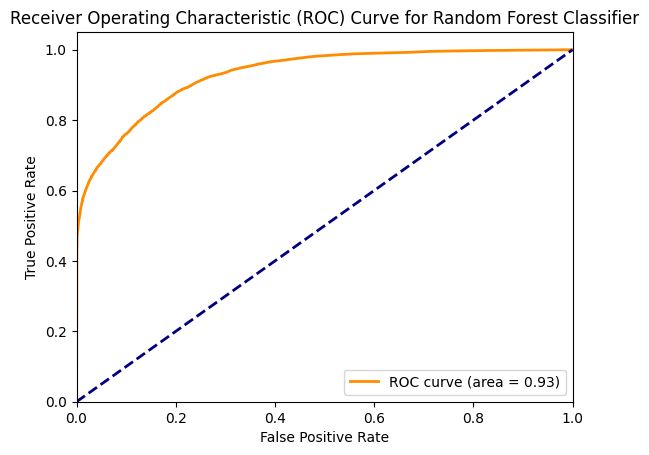

In [48]:
y_score = rf_reduced.predict_proba(X_test_reduced)[:, 1]

# Calculate ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest Classifier')
plt.legend(loc="lower right")
plt.show()

Random Forest Classifier:
* High Accuracy and Balance: The Random Forest model has high overall accuracy (85.08%) and demonstrates a good balance between precision and recall across both classes (0 and 1).
* Better Recall for Class 0: This model has a very good recall for class 0 (93%), indicating it is very effective at identifying the "not cancelled" class.
* Has the highest AUC of 0.93, indicating a very good model performance with a high true positive rate and a low false positive rate.
* The ROC curve stays well above the diagonal line, suggesting that the model does a good job distinguishing between the positive and negative classes.


**Logistic Regression**

In [49]:
#Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_reduced, y_train)
y_pred_lr = lr.predict(X_test_reduced)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
report_lr = classification_report(y_test, y_pred_lr)
print("Logistic Regression Classifier:")
print("Accuracy: ",accuracy_lr)
print("Classification report: ",report_lr)


Logistic Regression Classifier:
Accuracy:  0.7107508151324311
Classification report:                precision    recall  f1-score   support

           0       0.73      0.88      0.79     14301
           1       0.66      0.42      0.51      8088

    accuracy                           0.71     22389
   macro avg       0.69      0.65      0.65     22389
weighted avg       0.70      0.71      0.69     22389



c:\Users\1ga17\AppData\Local\pypoetry\Cache\virtualenvs\analysing-booking-data-for-major-hotel-cha-A-_WXSVA-py3.11\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROC-AUC for Logistic Regression

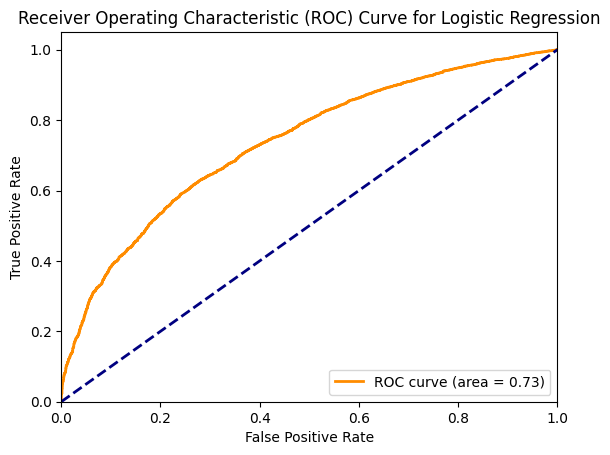

In [44]:
y_score = lr.predict_proba(X_test_reduced)[:, 1]

# Calculate ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

Logistic Regression Classifier:
* Lower Accuracy: Logistic Regression has a lower overall accuracy (71.06%) compared to Random Forest.
* Recall Discrepancy: There is a considerable discrepancy in recall between class 0 (88%) and class 1 (42%), indicating the model is less effective at identifying the "cancelled" class.
* Shows the lowest AUC of 0.73, which suggests that it is less capable of distinguishing between the positive and negative classes compared to the other models.
* The ROC curve is closer to the diagonal line than the other two models, which indicates poorer performance.

**XGBoost**

In [50]:
#XGBoost Classifier
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_reduced, y_train)
y_pred_xgb = xgb.predict(X_test_reduced)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb)
print("XGBoost Classifier:")
print("Accuracy: ",accuracy_xgb)
print("Classification report: ",report_xgb)


XGBoost Classifier:
Accuracy:  0.827459913350306
Classification report:                precision    recall  f1-score   support

           0       0.84      0.90      0.87     14301
           1       0.80      0.70      0.74      8088

    accuracy                           0.83     22389
   macro avg       0.82      0.80      0.81     22389
weighted avg       0.83      0.83      0.82     22389



ROC-AUC for XGBoost

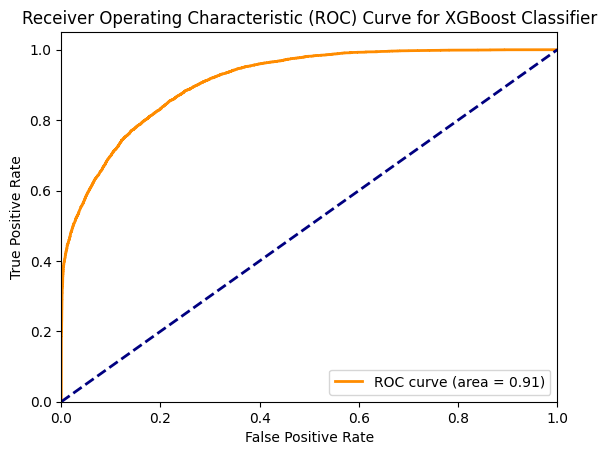

In [46]:

y_score = xgb.predict_proba(X_test_reduced)[:, 1]

# Calculate ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for XGBoost Classifier')
plt.legend(loc="lower right")
plt.show()

XGBoost Classifier:
* Higher Accuracy Than Logistic Regression: XGBoost improves upon the accuracy of Logistic Regression with 82.75% but is slightly lower than Random Forest.
* Better Recall for Class 1: With a recall of 70% for class 1, XGBoost is better at identifying "cancelled" bookings than Logistic Regression, though slightly less so than Random Forest.
* Precision-Recall Balance: XGBoost has a more balanced precision-recall tradeoff for both classes than Logistic Regression, which is particularly important in imbalanced datasets.
* Has a high AUC of 0.91, which is close to that of the Random Forest model, signifying strong performance.
* The ROC curve for XGBoost is closer to the top left corner than Logistic Regression, indicating a better true positive rate across different thresholds.

**The ensemble methods, Random Forest and XGBoost, demonstrate superior performance over the Logistic Regression model in predicting booking cancellations. Random Forest slightly edges out XGBoost in terms of the ROC-AUC metric, showcasing its strength in distinguishing between classes. XGBoost, while having a marginally lower AUC, provides a more balanced classification performance, particularly for the positive class, which is often more critical in cancellation predictions. On the other hand, Logistic Regression, despite being the least accurate, offers a computationally less demanding alternative that can be useful as an initial benchmark model.**